# Load a model and test performance

In [1]:
%matplotlib inline
import numpy as np
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
import os
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Point to current results path for previously trained model:

In [2]:
resultPath = 'results/0122_mimic+csu/'

In [3]:
epochAvgLoss = np.loadtxt(os.path.join(resultPath, 'epochAvgLoss.gz'))
epochAvgLossValid = np.loadtxt(os.path.join(resultPath, 'epochAvgLossValid.gz'))
yDev = np.loadtxt(os.path.join(resultPath, 'yDev.gz'))
yTrain = np.loadtxt(os.path.join(resultPath, 'yTrain.gz'))
epochPredictions = np.loadtxt(os.path.join(resultPath, 'epochPreds.gz'))
predsRealShape = np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)
epochPredictions = epochPredictions.reshape(predsRealShape)

In [4]:
with open(os.path.join(resultPath, 'hyperParamDict.pickle'), 'rb') as handle:
    hyperParamDict = pickle.load(handle)
pp.pprint(hyperParamDict)

{   'EMBED_SIZE': 300,
    'batchSize': 256,
    'inputKeepProb': 1,
    'learningRate': 0.001,
    'maxGradNorm': 5,
    'maxNoteLength': 1000,
    'n_hidden': 200,
    'numLayers': 1,
    'outputKeepProb': 0.5,
    'sizeList': [200, 150, 75, 19],
    'trainingEpochsMax': 100}


In [5]:
predsRaw = scipy.special.expit(epochPredictions)# this is sigmoid function applied element wise
preds = predsRaw
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
bestEpoch = np.argmin(epochAvgLossValid)
nEpochs = epochPredictions.shape[0]

In [6]:
bestEpoch = np.argmin(epochAvgLossValid)
print('best model at epoch %d with a validation loss of %.5f'%(bestEpoch, epochAvgLossValid[bestEpoch]))

best model at epoch 10 with a validation loss of 0.26862


In [7]:
precOverEpoch = np.zeros(preds.shape[0])
recOverEpoch = np.zeros(preds.shape[0])
f1OverEpoch = np.zeros(preds.shape[0])
coverErrOverEpoch = np.zeros(preds.shape[0])
rankLossOverEpoch = np.zeros(preds.shape[0])
lrapOverEpoch = np.zeros(preds.shape[0])
for epoch in range(preds.shape[0]):
    prec = metrics.precision_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    rec = metrics.recall_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    f1 = metrics.f1_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    coverErr = metrics.coverage_error(yDev, predsRaw[epoch, :,:])
    rankLoss = metrics.label_ranking_loss(yDev, predsRaw[epoch,:,:])
    lrap = metrics.label_ranking_average_precision_score(yDev, predsRaw[epoch,:,:])
    coverErrOverEpoch[epoch] = coverErr
    rankLossOverEpoch[epoch] = rankLoss
    lrapOverEpoch[epoch] = lrap
    precOverEpoch[epoch] = prec
    recOverEpoch[epoch] = rec
    f1OverEpoch[epoch] = f1

/usr/lib64/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/lib64/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
prec = metrics.precision_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
rec = metrics.recall_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
f1 = metrics.f1_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
print('Precsion score averaged over samples %3f'%(prec))
print('Recall score averaged over samples %3f'%(rec))
print('F1 score averaged over samples %3f'%(f1))
print('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])
with open(os.path.join(resultPath, 'bestPerformance.txt'), 'w') as performanceFile:
    performanceFile.write('Precsion score averaged over samples %f \n'%(prec))
    performanceFile.write('Recall score averaged over samples %f \n'%(rec))
    performanceFile.write('F1 score averaged over samples %f \n'%(f1))
    performanceFile.write('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])

Precsion score averaged over samples 0.827188
Recall score averaged over samples 0.661033
F1 score averaged over samples 0.693760
Rank loss 0.365007 



/usr/lib64/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/lib64/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5,0,'Epochs')

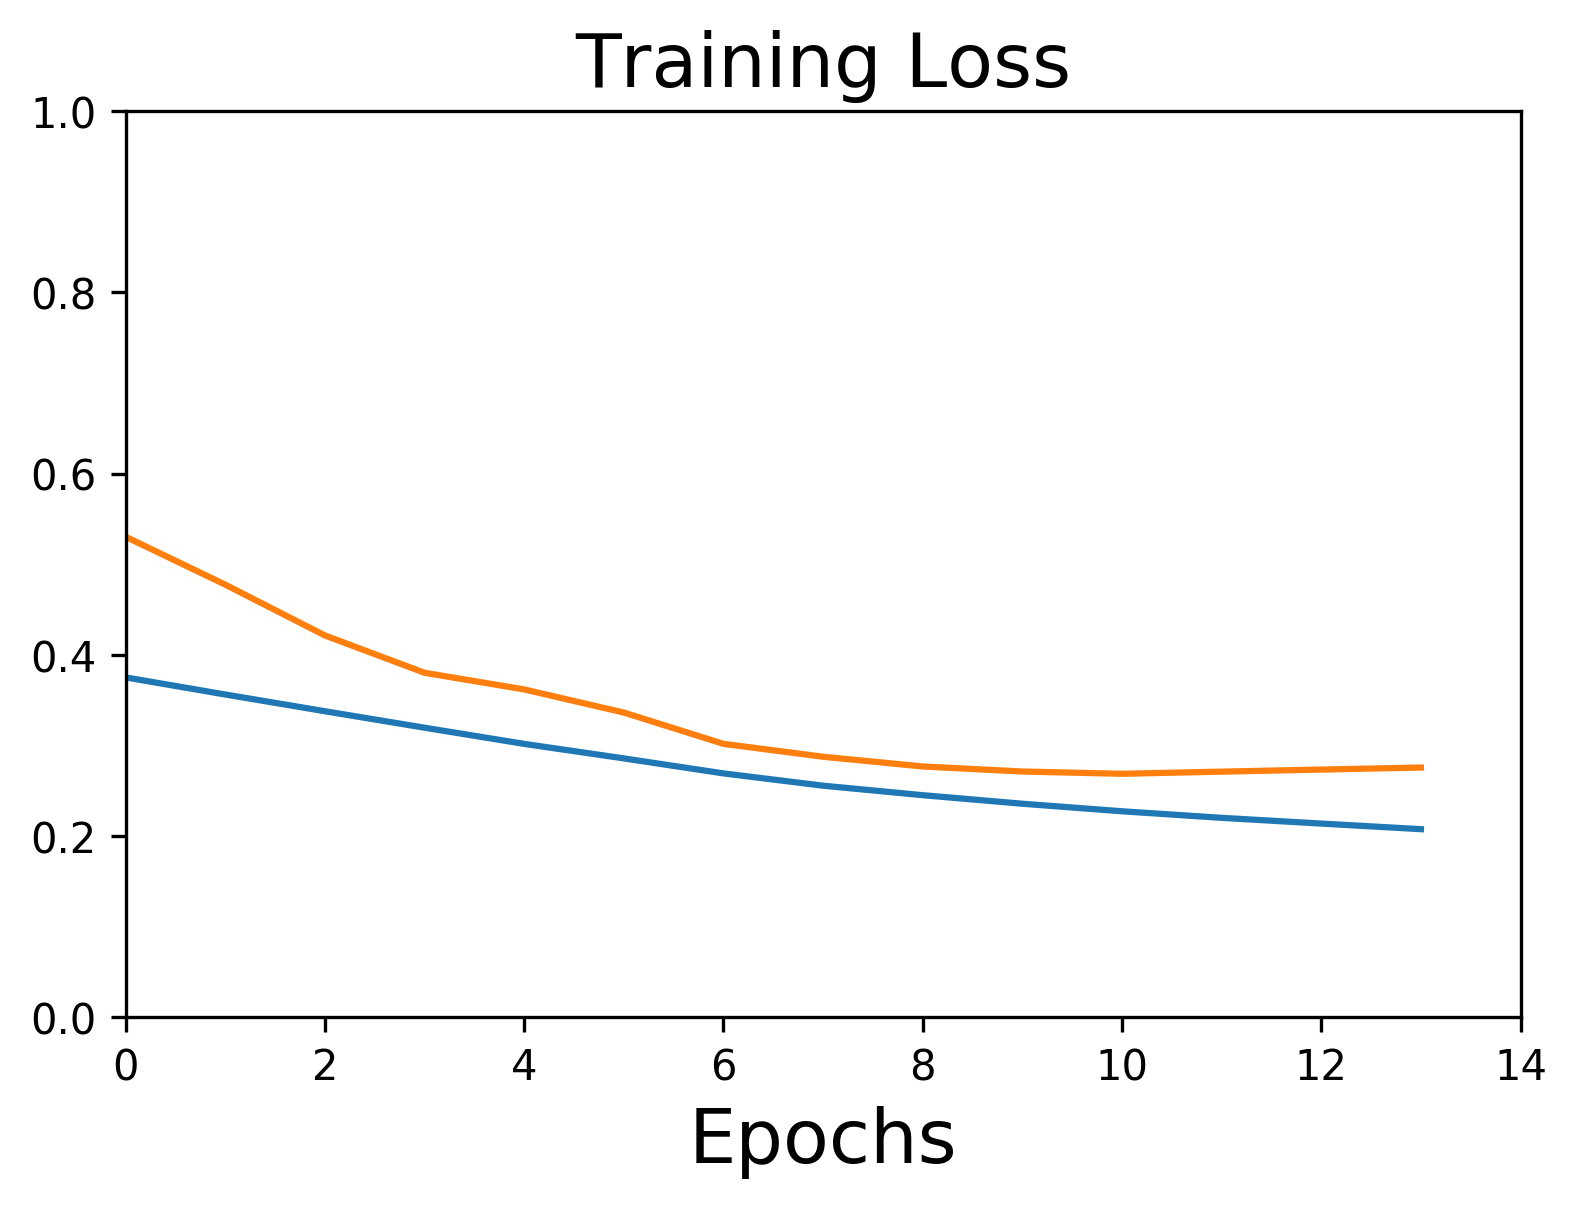

In [9]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, epochAvgLoss)
plt.plot(x, epochAvgLossValid)
plt.axis([0, epochPredictions.shape[0], 0, 1.0])
plt.title('Training Loss', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)

Text(0.5,0,'Epochs')

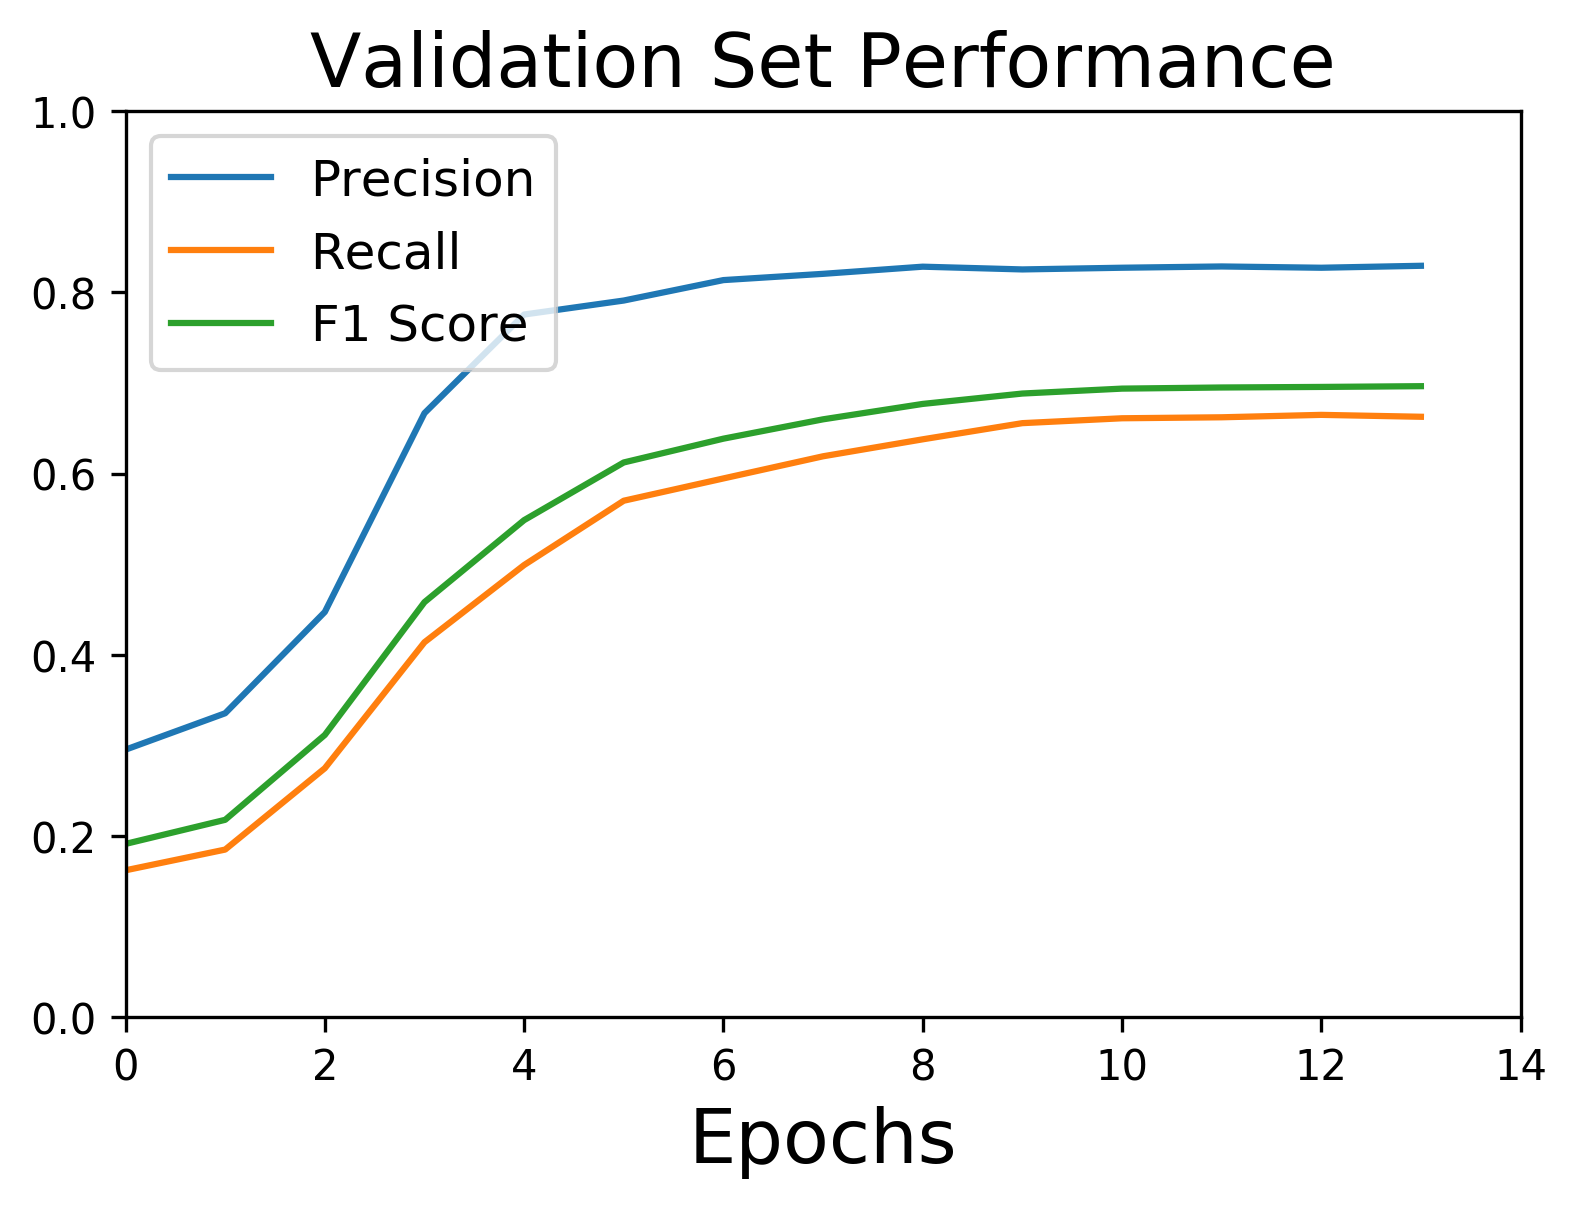

In [10]:
nEpochs = preds.shape[0]
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, precOverEpoch)
plt.plot(x, recOverEpoch)
plt.plot(x, f1OverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Precision', 'Recall', 'F1 Score'], loc='upper left', fontsize = 12)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)

Text(0.5,0,'Epochs')

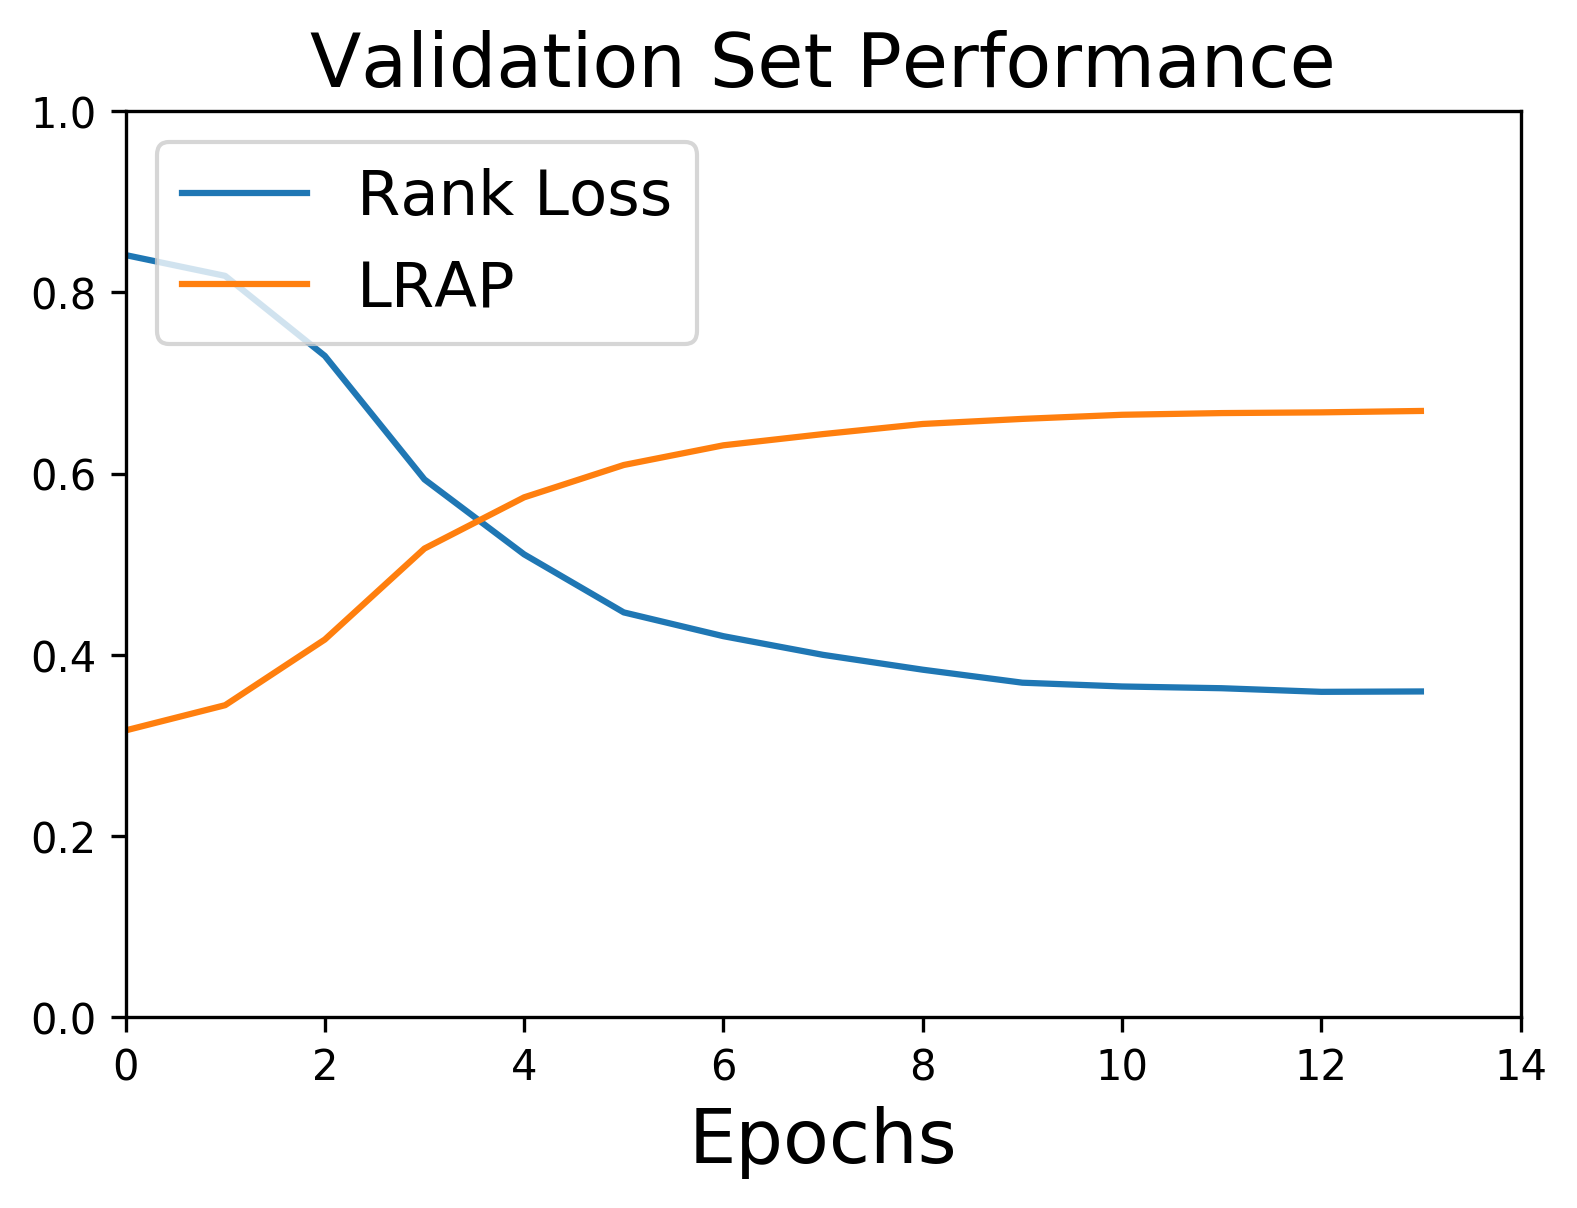

In [11]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, rankLossOverEpoch)
plt.plot(x, lrapOverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Rank Loss', 'LRAP'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)

The mean number of codes in the devSet is 3.760


Text(0.5,0,'Epochs')

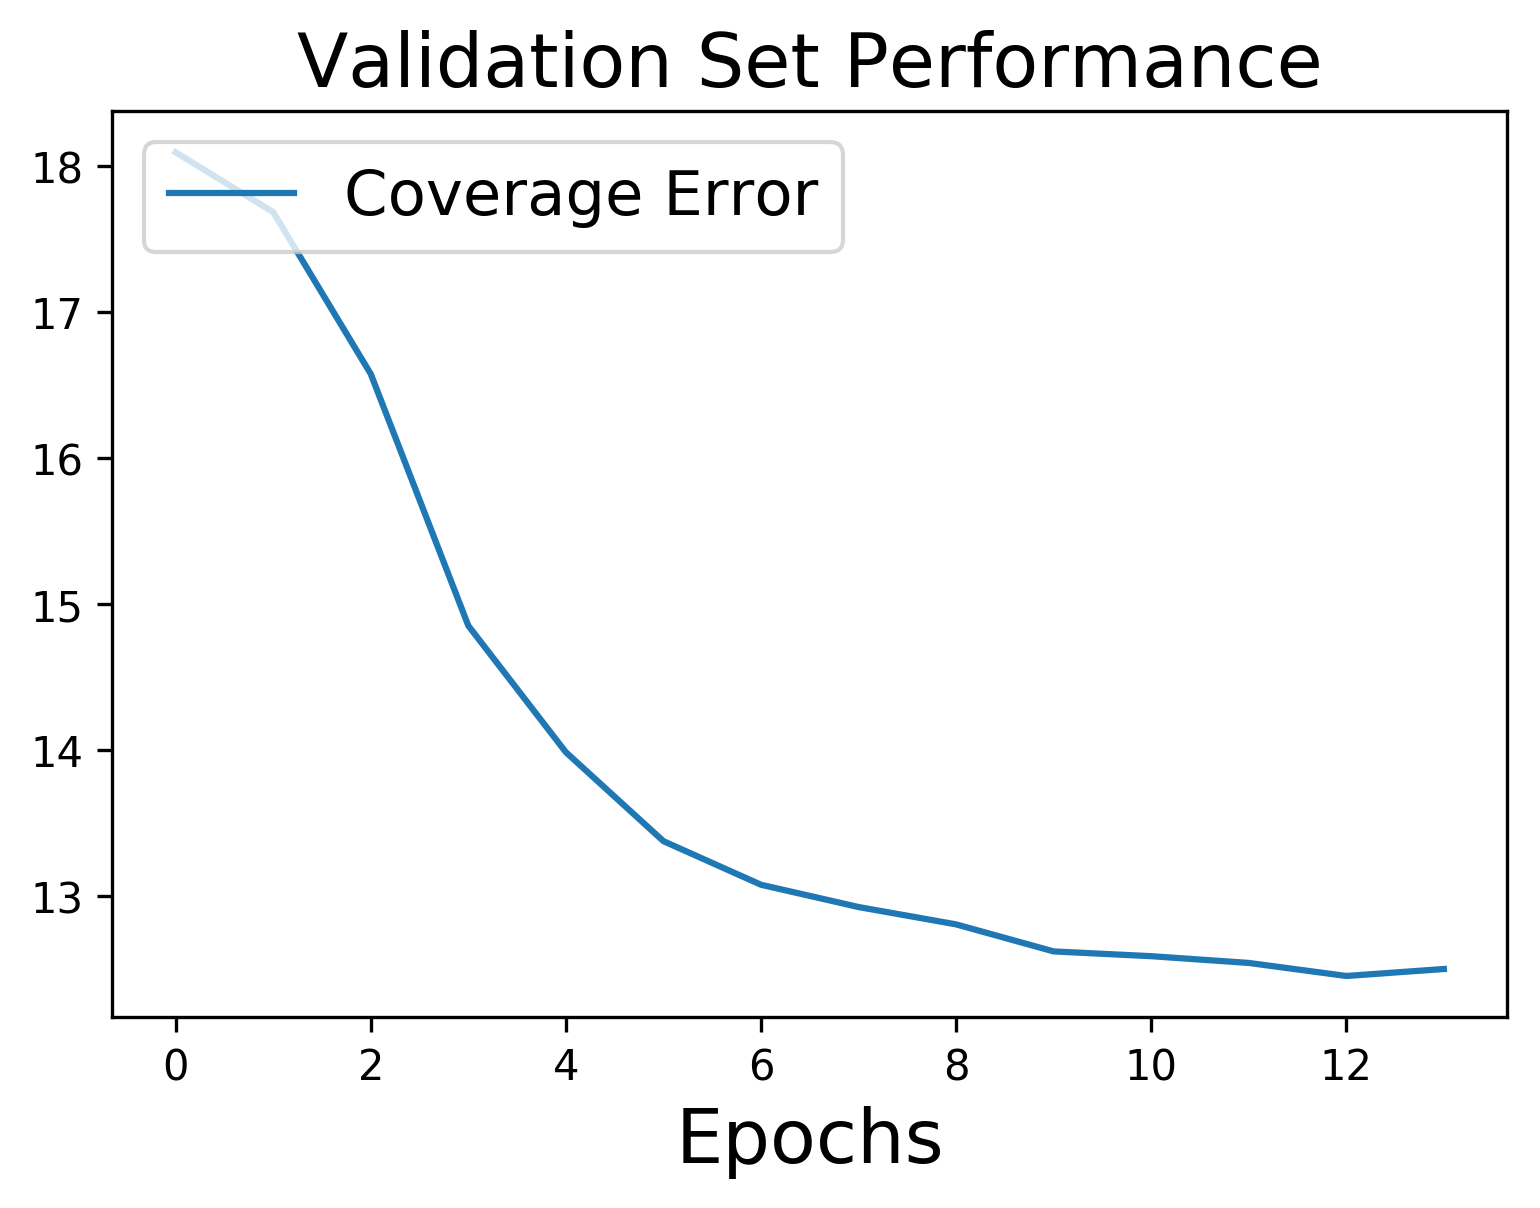

In [12]:
meanNumberOfCodes = np.sum(yDev, axis = 1)
meanNumberOfCodes = np.mean(meanNumberOfCodes)
print('The mean number of codes in the devSet is %.3f'%meanNumberOfCodes)
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, coverErrOverEpoch)

plt.legend(['Coverage Error'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)

In [13]:
with open(os.path.join(resultPath, 'features.pkl'), 'rb') as handle:
    icdDict = pickle.load(handle)[2]
pp.pprint(icdDict)

{   'cat:1': 8,
    'cat:10': 16,
    'cat:11': 15,
    'cat:12': 14,
    'cat:13': 13,
    'cat:14': 12,
    'cat:15': 11,
    'cat:16': 10,
    'cat:17': 9,
    'cat:18': 18,
    'cat:19': 17,
    'cat:2': 7,
    'cat:3': 6,
    'cat:4': 5,
    'cat:5': 4,
    'cat:6': 3,
    'cat:7': 2,
    'cat:8': 1,
    'cat:9': 0}


In [14]:
myMapper = {'cat:1': 'ICD_001_139',
                 'cat:10': 'ICD_520_579',
                 'cat:11': 'ICD_580_629',
                 'cat:12': 'ICD_630_679',
                 'cat:13': 'ICD_680_709',
                 'cat:14': 'ICD_710_739',
                 'cat:15': 'ICD_740_759',
                 'cat:16': 'ICD_760_779',
                 'cat:17': 'ICD_780_799',
                 'cat:18': 'ICD_800_999',
                 'cat:19': 'ICD_EV',
                 'cat:2': 'ICD_140_239',
                 'cat:3': 'ICD_240_279',
                 'cat:4': 'ICD_280_289',
                 'cat:5': 'ICD_290_319',
                 'cat:6': 'ICD_320_359',
                 'cat:7': 'ICD_360_389',
                 'cat:8': 'ICD_390_459',
                 'cat:9': 'ICD_460_519'}

In [15]:
sorted(icdDict.keys())

['cat:1',
 'cat:10',
 'cat:11',
 'cat:12',
 'cat:13',
 'cat:14',
 'cat:15',
 'cat:16',
 'cat:17',
 'cat:18',
 'cat:19',
 'cat:2',
 'cat:3',
 'cat:4',
 'cat:5',
 'cat:6',
 'cat:7',
 'cat:8',
 'cat:9']

In [16]:
xAxisLabels = ['']*len(icdDict.keys())
xAxisOriginalOrder = ['']*len(icdDict.keys())
for icdKey, idx in icdDict.items():
#     print(icdKey)
#     print(idx)
    xAxisLabels[idx] = myMapper[icdKey]
    xAxisOriginalOrder[idx] = idx
print(xAxisLabels)
print(xAxisOriginalOrder)
sortedAxisLabels = np.argsort(xAxisLabels)
[xAxisLabels[sortedIdx] for sortedIdx in sortedAxisLabels]

['ICD_460_519', 'ICD_390_459', 'ICD_360_389', 'ICD_320_359', 'ICD_290_319', 'ICD_280_289', 'ICD_240_279', 'ICD_140_239', 'ICD_001_139', 'ICD_780_799', 'ICD_760_779', 'ICD_740_759', 'ICD_710_739', 'ICD_680_709', 'ICD_630_679', 'ICD_580_629', 'ICD_520_579', 'ICD_EV', 'ICD_800_999']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


['ICD_001_139',
 'ICD_140_239',
 'ICD_240_279',
 'ICD_280_289',
 'ICD_290_319',
 'ICD_320_359',
 'ICD_360_389',
 'ICD_390_459',
 'ICD_460_519',
 'ICD_520_579',
 'ICD_580_629',
 'ICD_630_679',
 'ICD_680_709',
 'ICD_710_739',
 'ICD_740_759',
 'ICD_760_779',
 'ICD_780_799',
 'ICD_800_999',
 'ICD_EV']

In [17]:
predsBest = preds[bestEpoch,:,:]
yTruth = yDev
classTrainingExamples = np.sum(yTrain, axis = 0)
diseaseSpecificScores_F1 = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Prec = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Rec = np.zeros(classTrainingExamples.shape)
for colIdx in range(yTruth.shape[1]):
    currTruth = yTruth[:, colIdx]
    currPred = predsBest[:, colIdx]
    confMat = metrics.confusion_matrix(y_true = currTruth, y_pred = currPred)
    prec = metrics.precision_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    rec = metrics.recall_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    f1 = metrics.f1_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    diseaseSpecificScores_F1[colIdx] = f1
    diseaseSpecificScores_Prec[colIdx] = prec
    diseaseSpecificScores_Rec[colIdx] = rec
    print('total positives {} or {} of the total'.format(np.sum(currPred), np.mean(currPred)))
    print('For Column {}'.format(colIdx))
    print('f1 score {}'.format(f1))
    print('Number of training examples {}'.format(classTrainingExamples[colIdx]))
    print('Percent of training examples {}'.format(classTrainingExamples[colIdx]/yTrain.shape[0]))
    print('***************************')

total positives 8949.0 or 0.2242070451470662 of the total
For Column 0
f1 score 0.721646262047408
Number of training examples 25653.0
Percent of training examples 0.2505200246096153
***************************
total positives 13172.0 or 0.3300095204690084 of the total
For Column 1
f1 score 0.8819655146895582
Number of training examples 36214.0
Percent of training examples 0.35365579741989667
***************************
total positives 4585.0 or 0.11487197474570326 of the total
For Column 2
f1 score 0.7119651347068146
Number of training examples 13282.0
Percent of training examples 0.129708297932597
***************************
total positives 5332.0 or 0.13358721250688982 of the total
For Column 3
f1 score 0.593973442288049
Number of training examples 14457.0
Percent of training examples 0.1411830193654235
***************************
total positives 908.0 or 0.0227489101568372 of the total
For Column 4
f1 score 0.215426902594056
Number of training examples 11329.0
Percent of training ex

/usr/lib64/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib64/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


total positives 12356.0 or 0.30956556596682866 of the total
For Column 16
f1 score 0.736749328953167
Number of training examples 30601.0
Percent of training examples 0.29884080899227533
***************************
total positives 3133.0 or 0.07849376158741293 of the total
For Column 17
f1 score 0.4287659165532153
Number of training examples 27072.0
Percent of training examples 0.2643775818123224
***************************
total positives 4577.0 or 0.11467154381921131 of the total
For Column 18
f1 score 0.5387337197922156
Number of training examples 23032.0
Percent of training examples 0.224924071524136
***************************


In [18]:
xAxisLabels = ['']*len(icdDict.keys())
xAxisOriginalOrder = ['']*len(icdDict.keys())
for icdKey, idx in icdDict.items():
    xAxisLabels[idx] = myMapper[icdKey]
    xAxisOriginalOrder[idx] = idx
print(xAxisLabels)
print(xAxisOriginalOrder)
sortedAxisLabels = np.argsort(xAxisLabels)
[xAxisLabels[sortedIdx] for sortedIdx in sortedAxisLabels]

['ICD_460_519', 'ICD_390_459', 'ICD_360_389', 'ICD_320_359', 'ICD_290_319', 'ICD_280_289', 'ICD_240_279', 'ICD_140_239', 'ICD_001_139', 'ICD_780_799', 'ICD_760_779', 'ICD_740_759', 'ICD_710_739', 'ICD_680_709', 'ICD_630_679', 'ICD_580_629', 'ICD_520_579', 'ICD_EV', 'ICD_800_999']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


['ICD_001_139',
 'ICD_140_239',
 'ICD_240_279',
 'ICD_280_289',
 'ICD_290_319',
 'ICD_320_359',
 'ICD_360_389',
 'ICD_390_459',
 'ICD_460_519',
 'ICD_520_579',
 'ICD_580_629',
 'ICD_630_679',
 'ICD_680_709',
 'ICD_710_739',
 'ICD_740_759',
 'ICD_760_779',
 'ICD_780_799',
 'ICD_800_999',
 'ICD_EV']

/usr/lib64/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib64/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


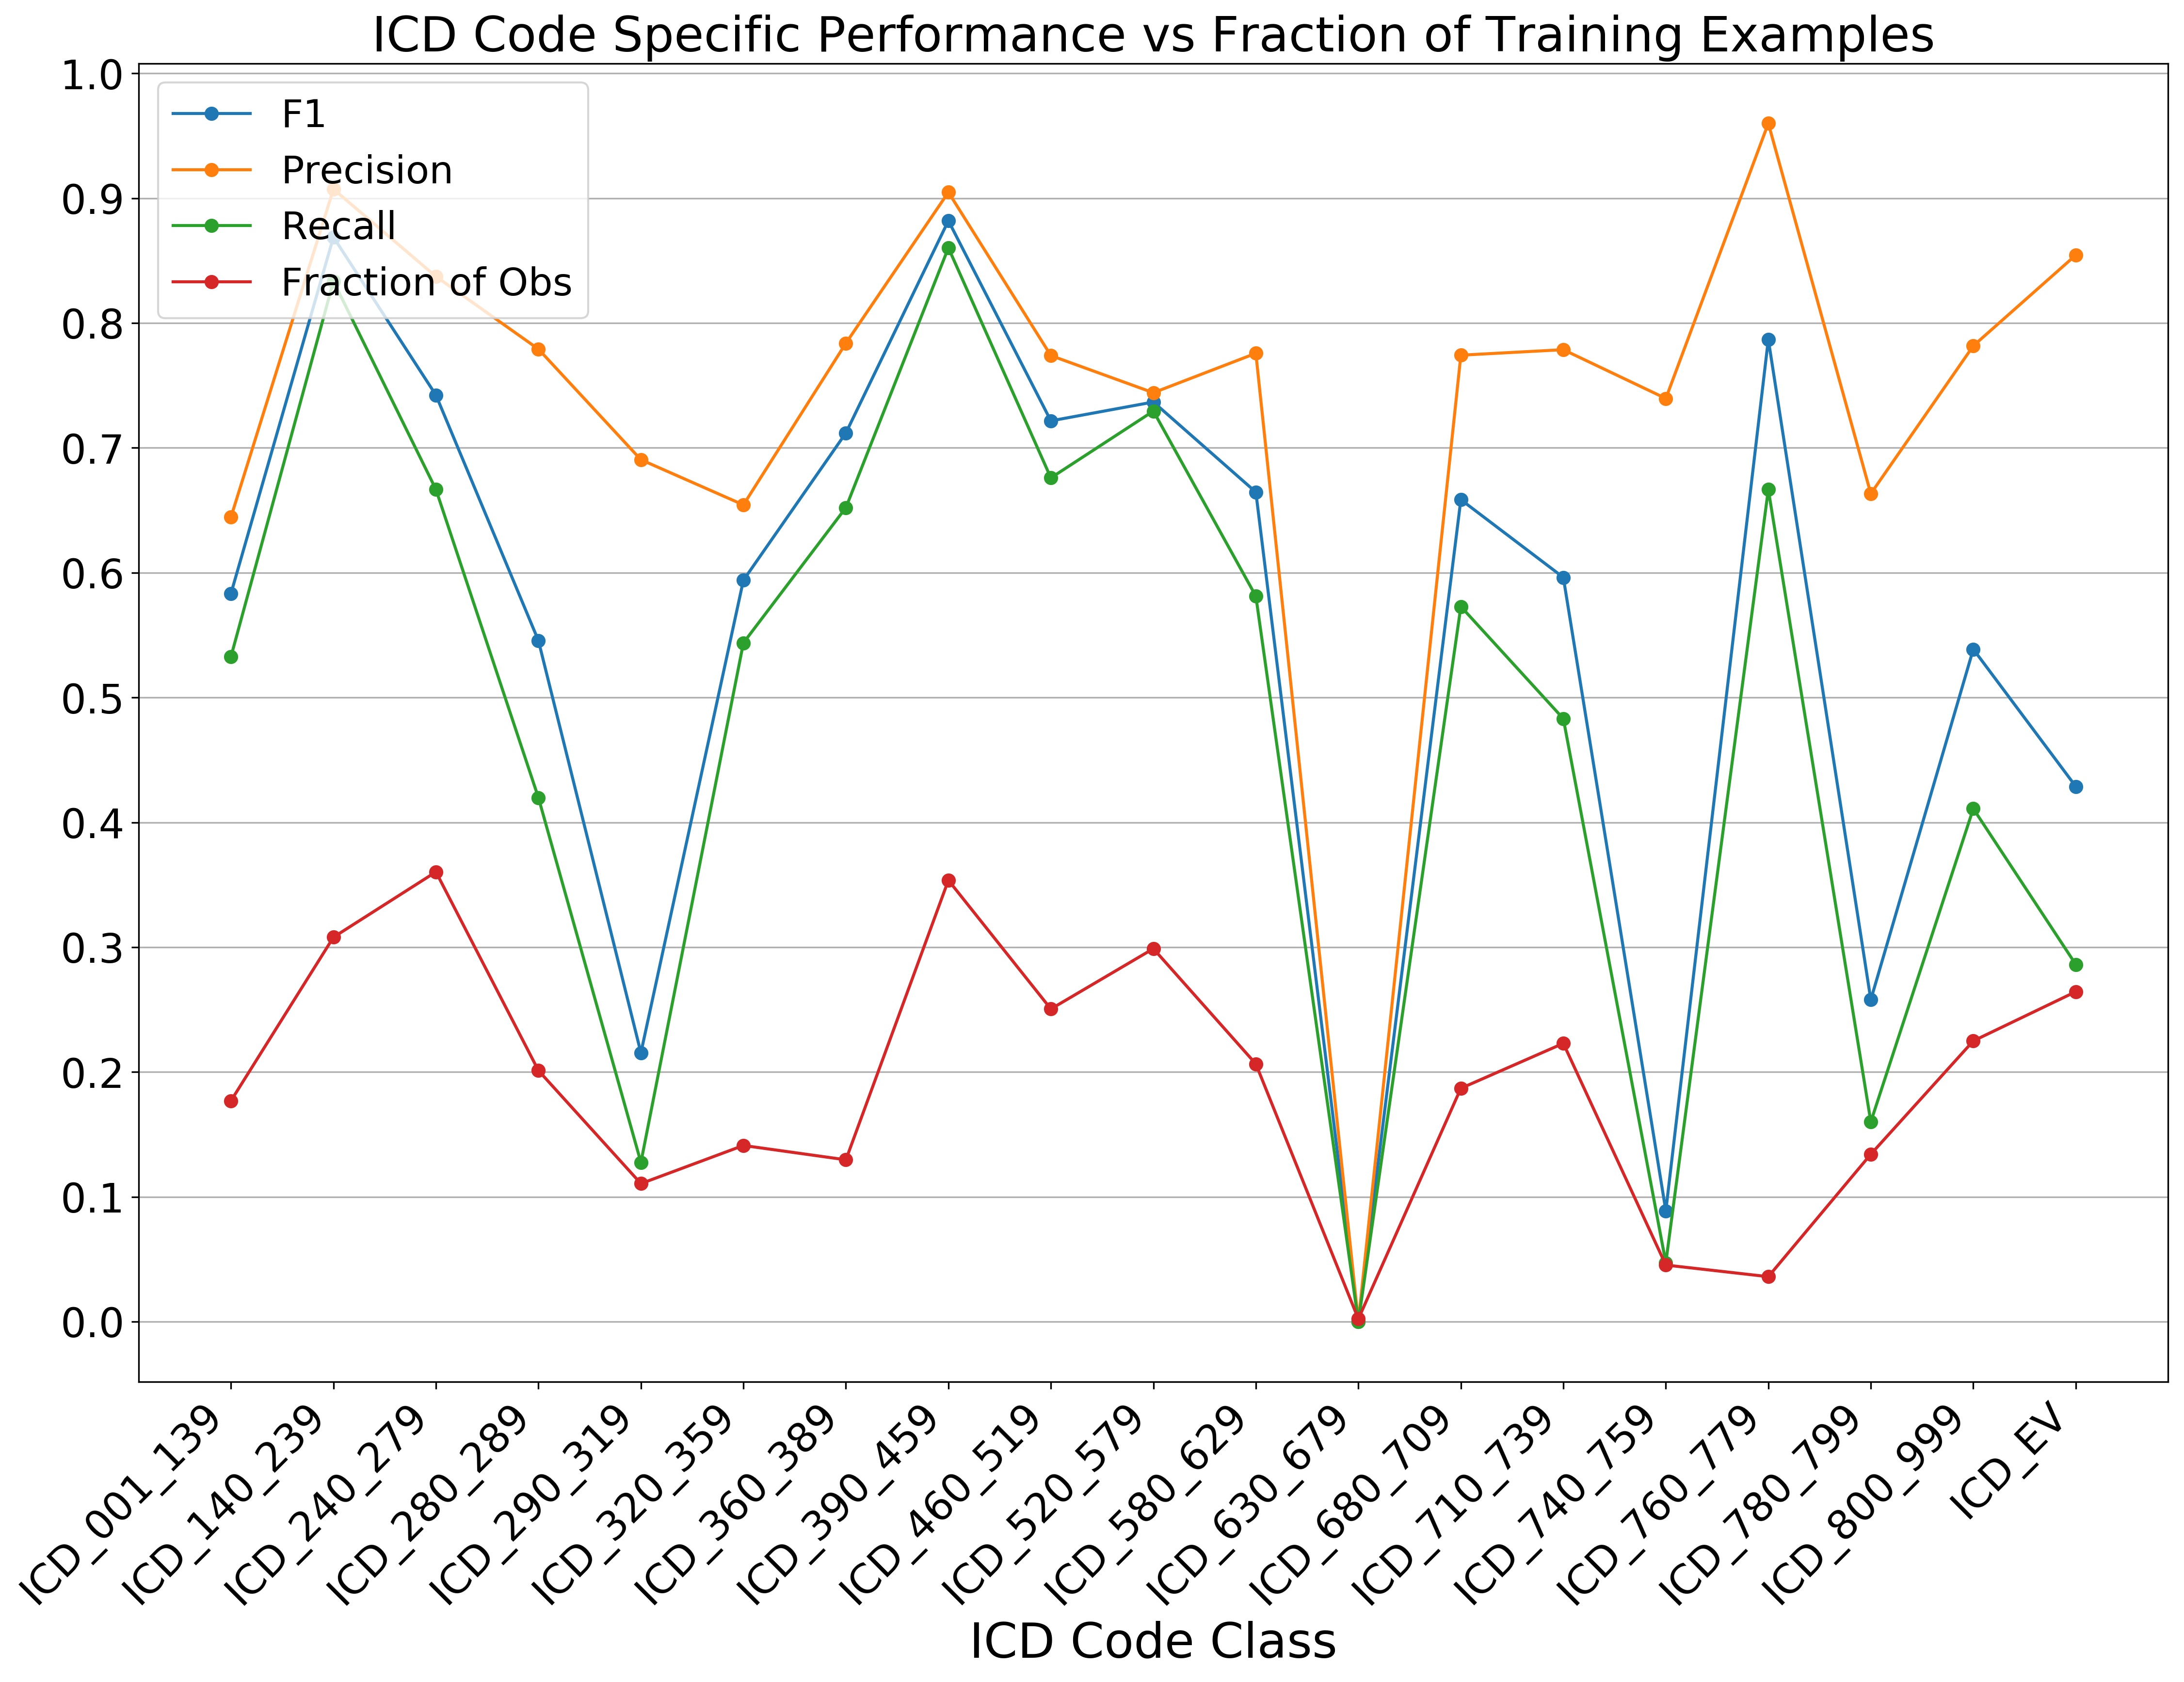

In [19]:
predsBest = preds[bestEpoch,:,:]
yTruth = yDev
classTrainingExamples = np.sum(yTrain, axis = 0)

diseaseSpecificScores_F1 = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Prec = np.zeros(classTrainingExamples.shape)
diseaseSpecificScores_Rec = np.zeros(classTrainingExamples.shape)
for colIdx in range(yTruth.shape[1]):
    currTruth = yTruth[:, colIdx]
    currPred = predsBest[:, colIdx]
    confMat = metrics.confusion_matrix(y_true = currTruth, y_pred = currPred)
    prec = metrics.precision_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    rec = metrics.recall_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    f1 = metrics.f1_score(y_pred = currPred, y_true= currTruth, average = 'binary')
    diseaseSpecificScores_F1[colIdx] = f1
    diseaseSpecificScores_Prec[colIdx] = prec
    diseaseSpecificScores_Rec[colIdx] = rec

nClasses = yTrain.shape[1]
width = 18
height = 12
fig = plt.figure(dpi = 300, figsize=(width, height))
x = range(1, nClasses + 1)
diseaseSpecificScores_F1 = [diseaseSpecificScores_F1[sortedIdx] for sortedIdx in sortedAxisLabels]
diseaseSpecificScores_Prec = [diseaseSpecificScores_Prec[sortedIdx] for sortedIdx in sortedAxisLabels]
diseaseSpecificScores_Rec = [diseaseSpecificScores_Rec[sortedIdx] for sortedIdx in sortedAxisLabels]
plt.plot(x, diseaseSpecificScores_F1, linestyle='-', marker='o', label = 'F1')
plt.plot(x, diseaseSpecificScores_Prec, linestyle='-', marker='o', label = 'Precision')
plt.plot(x, diseaseSpecificScores_Rec, linestyle='-', marker='o', label = 'Recall')
factionOfObsPerDisease = classTrainingExamples/yTrain.shape[0]
factionOfObsPerDisease = [factionOfObsPerDisease[sortedIdx] for sortedIdx in sortedAxisLabels]
my_xticks = xAxisLabels
my_xticks = [my_xticks[sortedIdx] for sortedIdx in sortedAxisLabels]
plt.plot(x, factionOfObsPerDisease, linestyle='-', marker='o', label ='Fraction of Obs')
plt.xticks(np.arange(1, nClasses + 1, 1.0), my_xticks, rotation=45, ha = 'right')
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(loc='upper left', fontsize = 19)

plt.title('ICD Code Specific Performance vs Fraction of Training Examples', fontsize = 24)
plt.xlabel('ICD Code Class', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gca().yaxis.grid(True)

plt.show()
#fig.savefig(os.path.join(resultPath, 'diseaseSpecific.png'))

In [20]:
diseaseSpecificScores_F1

[0.58332728723790184,
 0.86883101438934485,
 0.74229712673546655,
 0.54560618697399355,
 0.215426902594056,
 0.59397344228804905,
 0.71196513470681455,
 0.88196551468955819,
 0.721646262047408,
 0.73674932895316703,
 0.66454932350886109,
 0.0,
 0.65854542817779704,
 0.59624618070711477,
 0.088805503439649769,
 0.78688524590163933,
 0.25793817317107287,
 0.53873371979221563,
 0.42876591655321528]